In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math

In [38]:
df_list = []
for file in os.listdir('data/'):
    temp_df = pd.read_csv('data/'+file)
    temp_df['p_id'] = int(file[:3])
    df_list.append(temp_df)
df = pd.concat(df_list).reset_index().drop('index', axis = 1)

In [39]:
df

,target_x,target_y,repeat_instructions.thisRepN,repeat_instructions.thisTrialN,repeat_instructions.thisN,repeat_instructions.thisIndex,accuracy_instructions.thisRepN,accuracy_instructions.thisTrialN,accuracy_instructions.thisN,accuracy_instructions.thisIndex,...,instr_adv_mouse_3_spd.x,instr_adv_mouse_3_spd.y,instr_adv_mouse_3_spd.leftButton,instr_adv_mouse_3_spd.midButton,instr_adv_mouse_3_spd.rightButton,instr_adv_mouse_3_spd.time,phase_cntdown.stopped,Unnamed: 281,repeat_instr_repeat.rt,Unnamed: 282
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46031,-0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(v1, v2)
    ab_magnitudes = np.linalg.norm(v1)
    ac_magnitudes = np.linalg.norm(v2)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))
    

  return np.nanmean(angles)

In [42]:
def comp_avg_ang_error(traj):
    try:
        end_point = np.tile(traj[-1], len(traj) - 1).reshape((len(traj) - 1, 2))
        curr_point = np.array(traj[:-1])
        next_point = np.array(traj[1:])
        
        angles = find_angles(curr_point, end_point, next_point)
        return angles
    except:
        return np.NaN

In [43]:
def comp_init_ang_error(traj, proportion=0.1):
    cutoff_dist = proportion*np.sqrt(0.3**2 + 0.3**2)

    try:
        for cutoff_point in traj:
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = cutoff_point - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        cross_prod = np.cross(v1, v2)
        if cross_prod < 0:
            sign = 1
        else:
            sign = -1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [44]:
def compute_errors(file, error_func):
    df_relearn = pd.read_csv(file)
    errors = []
    if error_func == 'init':
        func = comp_init_ang_error
    else:
        func = comp_avg_ang_error
    
    if type(df_relearn['cursor trajectory'].values[0]) == str:
        # if df_relearn['cursor trajectory'].values[0].contains('array'):
        for traj in df_relearn['cursor trajectory'].values:
        # print(type(traj))
            errors.append(func(ast.literal_eval(traj.replace('array', ''))))
        # else:

        #     for traj in df_relearn['cursor trajectory'].values:
        #         # print(type(traj))
        #         errors.append(func(ast.literal_eval(traj)))
    else:
        for traj in df_relearn['cursor trajectory'].values:
            # print(traj)
            errors.append(func(traj))

    if error_func == 'init':
        df_relearn['init signed errors'] = errors
    else:
        df_relearn['avg errors'] = errors

    num_participants = 62
    num_blocktrials = 64
    num_blocks = len(df_relearn)/(num_participants*num_blocktrials)

    df_relearn['trial'] = np.tile(np.arange(num_blocktrials*num_blocks), num_participants)
    df_relearn['block'] = np.tile(np.repeat(np.arange(num_blocks), num_blocktrials), num_participants)
    df_relearn.loc[df_relearn['p_id']%2 == 0, 'Rotation'] = 'Sudden'
    df_relearn.loc[df_relearn['p_id']%2 == 1, 'Rotation'] = 'Gradual'

    df_relearn.loc[df_relearn['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
    df_relearn.loc[df_relearn['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
    df_relearn.loc[df_relearn['p_id']%4 == 2, 'Emphasis'] = 'Speed'
    df_relearn.loc[df_relearn['p_id']%4 == 3, 'Emphasis'] = 'Speed'
    df_relearn.to_csv(file, index=False)
    return df_relearn

In [36]:
df_relearn = compute_errors('df_learn.csv', 'init')

C:\Users\tejas\AppData\Local\Temp\ipykernel_22564\3007452606.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
C:\Users\tejas\AppData\Local\Temp\ipykernel_22564\3007452606.py:24: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [33]:
# df_baseline = compute_errors('df_baseline.csv', 'avg')

In [13]:
df_baseline = pd.read_csv('df_baseline.csv')
df_learn = pd.read_csv('df_learn.csv')
df_unlearn = pd.read_csv('df_unlearn.csv')
df_relearn = pd.read_csv('df_relearn.csv')

df_baseline['phase'] = 'Baseline'
df_learn['phase'] = 'Learning'
df_unlearn['phase'] = 'Unlearning'
df_relearn['phase'] = 'Relearning'

In [29]:
df_learn['trial'] = np.tile(np.arange(64, 64*8), 62)
df_learn['block'] = np.tile(np.repeat(np.arange(1, 8), 64), 62)
df_unlearn['trial'] = np.tile(np.arange(64*8, 64*9), 62)
df_unlearn['block'] = np.tile(np.repeat(8, 64), 62)
df_relearn['trial'] = np.tile(np.arange(64*9, 64*11), 62)
df_relearn['block'] = np.tile(np.repeat([9, 10], 64), 62)
df_allphases = pd.concat([df_baseline, df_learn, df_unlearn, df_relearn]).drop('cursor trajectory', axis = 1).reset_index().drop('index', axis = 1)
df_allphases = df_allphases.fillna({'init signed errors': df_allphases['init signed errors'].ffill()})
df_allphases['init errors degrees'] = df_allphases['init errors']*180/np.pi
df_allphases['init signed errors degrees'] = df_allphases['init signed errors']*180/np.pi
df_allphases.to_csv('df_allphases.csv', index = False)


In [34]:
df_allphases_blockwise = df_allphases.groupby(['p_id', 'Rotation', 'Emphasis', 'block']).mean().reset_index()
df_allphases_blockwise.to_csv('df_allphases_blockwise.csv', index = False)

C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\3142754296.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_allphases_blockwise = df_allphases.groupby(['p_id', 'Rotation', 'Emphasis', 'block']).mean().reset_index()


In [40]:
# df_allphases['trial no'] = np.concatenate([np.tile(np.arange(64), 62), np.tile(np.arange(64*1, 64*8), 62), np.tile(np.arange(64*8, 64*9), 62), np.tile(np.arange(64*9, 64*11), 62)])
# df_allphases['block no'] = np.concatenate([np.tile(np.repeat(1, 64), 62), np.tile(np.repeat(np.arange(1, 8), 64), 62), np.tile(np.repeat(8, 64), 62), np.tile(np.repeat([9, 10], 64), 62)])


In [49]:
# df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'avg errors'] = -df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'avg errors']
# df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'init errors'] = -df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'init errors']

In [51]:
# df_allphases.to_csv('df_allphases.csv', index = False)

In [5]:
df_allphases = pd.read_csv('df_allphases.csv')
df_allphases['init signed errors degrees'] = df_allphases['init signed errors']*180/np.pi
df_allphases['init errors degrees'] = df_allphases['init errors']*180/np.pi
df_allphases['avg errors degrees'] = df_allphases['avg errors']*180/np.pi



In [8]:
df_allphases['block no'] = np.repeat(np.arange(11), 62*64)

In [10]:
df_allphases.to_csv('df_allphases.csv', index = False)

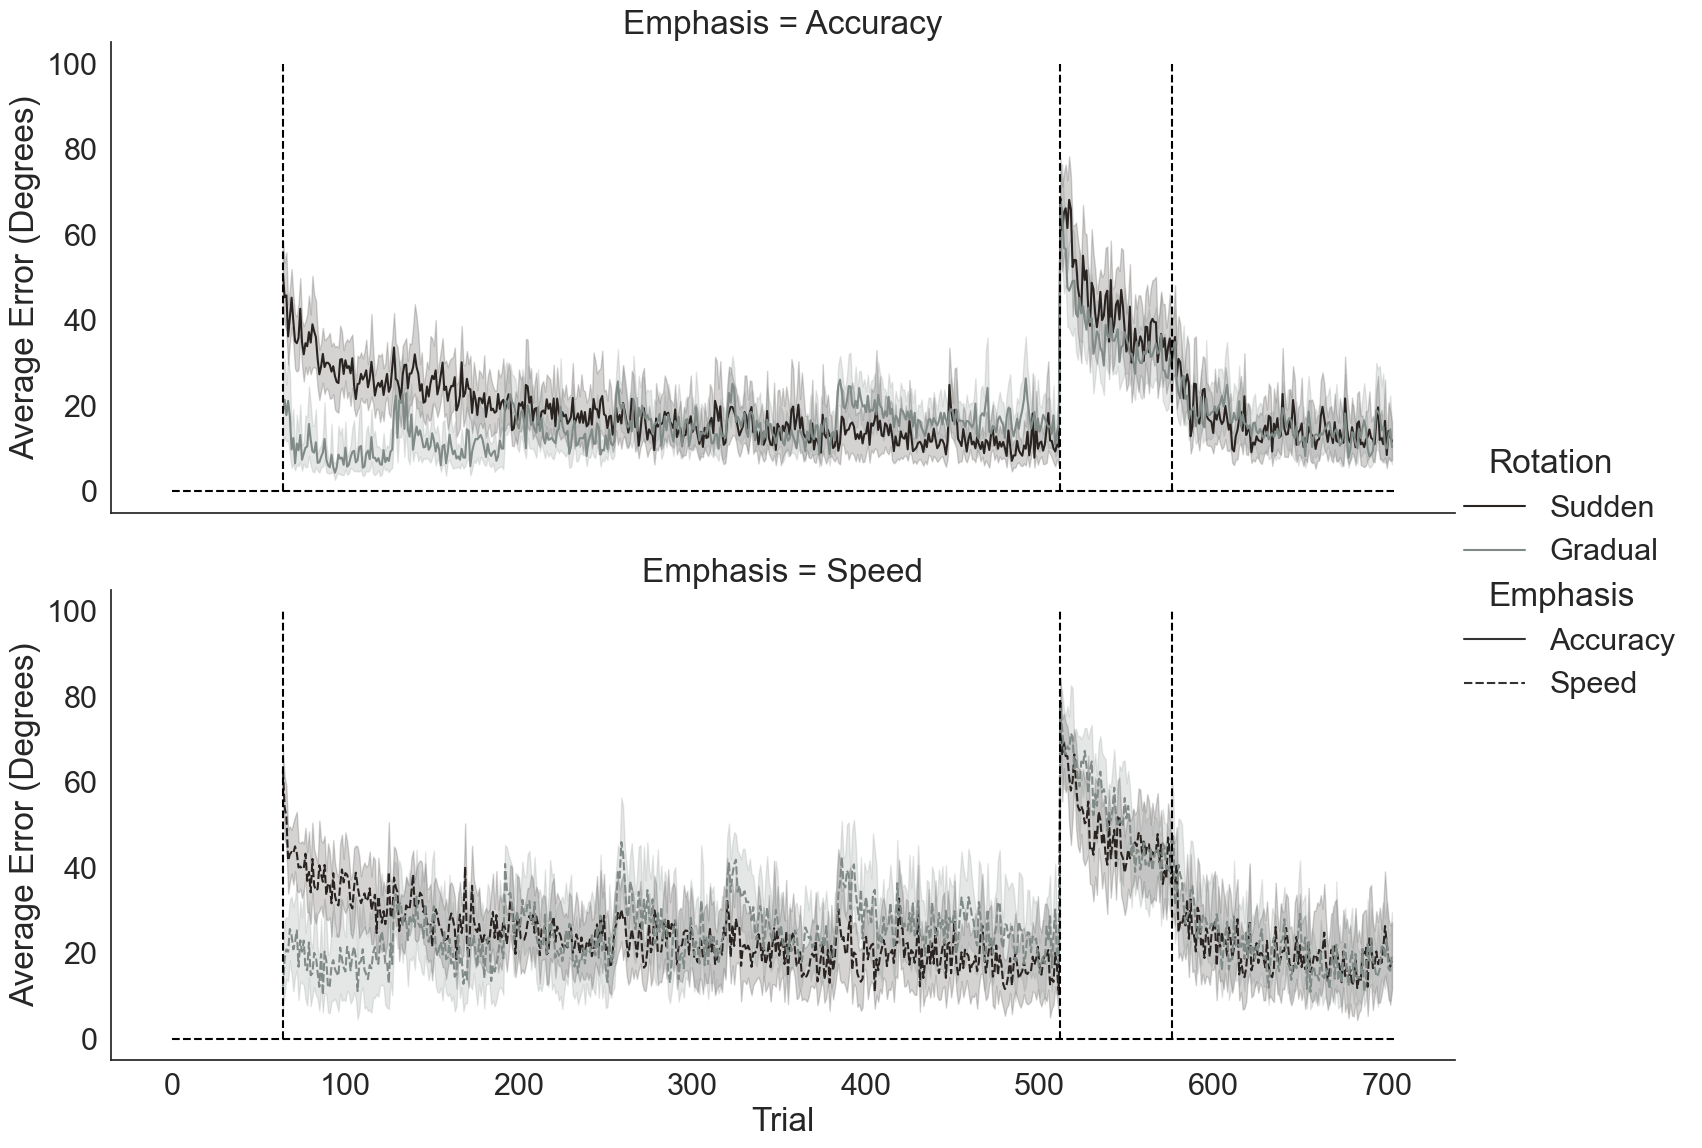

In [8]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial', y = 'avg errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_allphases, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Average Error (Degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=100, ymin = 0, color = 'black', linestyles = '--')
    ax.vlines(x = 512, ymax=100, ymin = 0, color = 'black', linestyles = '--')
    ax.vlines(x = 576, ymax=100, ymin = 0, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 704, color = 'black', linestyles = '--')

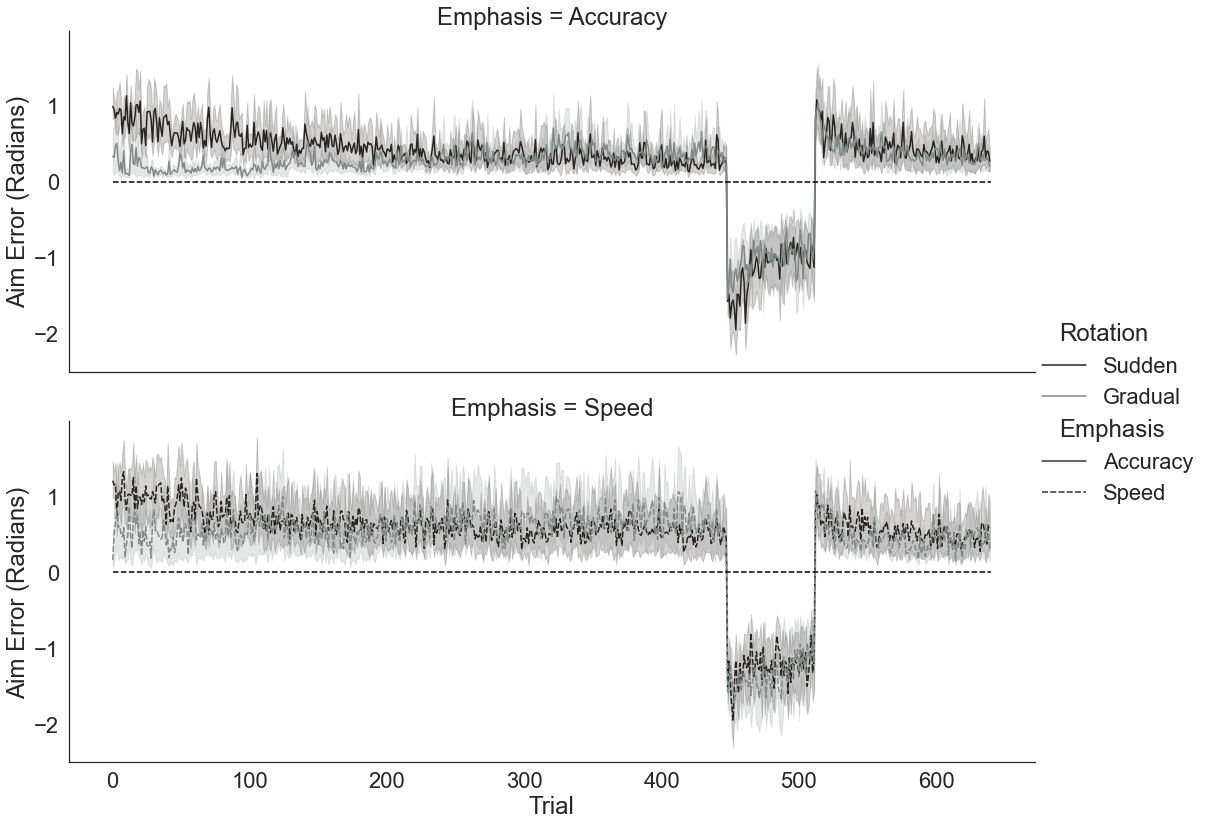

In [81]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial no', y = 'init errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_allphases, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Aim Error (Radians)')

# draw lines:
for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
#     ax.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

Text(0.5, 1.0, 'Relearning Phase')

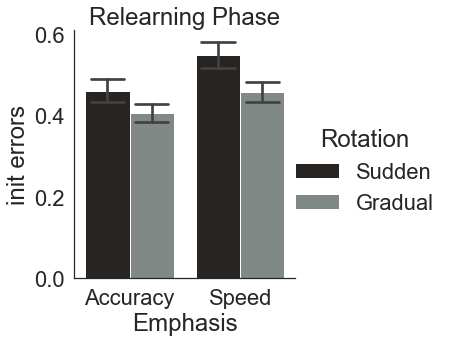

In [42]:
g = sns.catplot(x = 'Emphasis', y = 'init errors', hue = 'Rotation',   
                 hue_order=['Sudden', 'Gradual'],
            data = df_allphases.loc[df_allphases['phase'] == 'Relearning'], 
            kind = 'bar', capsize = 0.3)
plt.title('Relearning Phase')

In [44]:
df_allphases[['p_id', 'Rotation', 'Emphasis', 'phase', 'trial no', 'block no', 'avg errors', 'init errors', 'init signed errors']].to_csv('df_allphases.csv', index = False)

In [45]:
df_allphases = pd.read_csv('df_allphases.csv')
#Use data wrangler to compute and save blockwise 

,p_id,Rotation,Emphasis,phase,trial no,block no,avg errors,init errors
0,641,Gradual,Accuracy,Learning,0,0,0.276929,0.188780
1,641,Gradual,Accuracy,Learning,1,0,0.276929,0.188780
2,641,Gradual,Accuracy,Learning,2,0,0.146259,0.140401
3,641,Gradual,Accuracy,Learning,3,0,0.272961,0.291686
4,641,Gradual,Accuracy,Learning,4,0,0.588735,0.238112
...,...,...,...,...,...,...,...,...
39675,702,Sudden,Speed,Relearning,635,9,0.402465,1.203681
39676,702,Sudden,Speed,Relearning,636,9,0.827459,0.704598
39677,702,Sudden,Speed,Relearning,637,9,0.827459,0.704598
39678,702,Sudden,Speed,Relearning,638,9,0.715479,1.933589


In [11]:
df_allphases_blockwise = pd.read_csv('df_allphases_blockwise.csv')

In [50]:
df_allphases_blockwise['difference'] = df_allphases_blockwise['initsignederrors_mean'].diff(periods= 2)

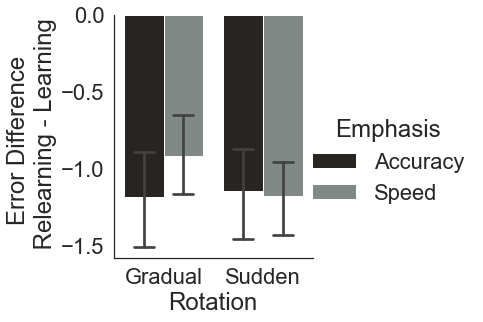

In [51]:
g = sns.catplot(y = 'difference', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['block no'] == 8))], 
            kind = 'bar', capsize = 0.2)
g.set_ylabels('Error Difference \n Relearning - Learning')


# Aim stuff begins here

In [249]:
df_aim = pd.read_csv('df_aim.csv')

In [250]:
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_x'] == 0.3)), 'optimal aim'] = 345/4
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_x'] == 0.3)), 'optimal aim'] = 75/4
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_x'] == -0.3)), 'optimal aim'] = 165/4
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_x'] == -0.3)), 'optimal aim'] = 255/4

In [251]:
df_aim['aim - optimal report'] = df_aim['aim report'] - df_aim['optimal aim']
df_aim.loc[df_aim['aim - optimal report'] > 45, 'aim - optimal report'] = 90 - df_aim.loc[df_aim['aim - optimal report'] > 45, 'aim - optimal report']
df_aim.loc[df_aim['aim - optimal report'] < -45, 'aim - optimal report'] = 90 + df_aim.loc[df_aim['aim - optimal report'] < -45, 'aim - optimal report']
df_aim['aim - optimal report'] = df_aim['aim - optimal report']*4

df_aim['trial'] = np.tile(np.arange(16), 62)
df_aim.loc[df_aim['p_id']%2 == 0, 'Rotation'] = 'Sudden'
df_aim.loc[df_aim['p_id']%2 == 1, 'Rotation'] = 'Gradual'

df_aim.loc[df_aim['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 2, 'Emphasis'] = 'Speed'
df_aim.loc[df_aim['p_id']%4 == 3, 'Emphasis'] = 'Speed'


In [291]:
def find_direction_angles(a, b, c, signed = True):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  ab_magnitudes = np.linalg.norm(ab)
  ac_magnitudes = np.linalg.norm(ac)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
  dotprod = np.dot(ab, ac)
  angle = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))
  crossprod = np.cross(ab, ac)
  if crossprod < 0:
    sign = -1
  else:
    sign = 1
  
  if not signed:
    sign = 1

  return sign*angle

In [300]:
swipe_angle = []
for i in range(len(df_aim)):
    traj = np.array([ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.x']), ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.y'])]).T
    target = np.array([df_aim.loc[i, 'target_x'], df_aim.loc[i, 'target_x']])
    swipe_angle.append(np.degrees(find_direction_angles(np.array([0, 0]), np.array([0, 1]), traj[-1])))

swipe_angle = np.array(swipe_angle)
swipe_angle[swipe_angle < 0] = 360 + swipe_angle[swipe_angle < 0]

C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\3679933500.py:11: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))


In [301]:
df_aim['swipe angle'] = np.array(swipe_angle)/4
df_aim['swipe - optimal report'] = df_aim['swipe angle'] - df_aim['optimal aim']
df_aim.loc[df_aim['swipe - optimal report'] > 45, 'swipe - optimal report'] = 90 - df_aim.loc[df_aim['swipe - optimal report'] > 45, 'swipe - optimal report']
df_aim.loc[df_aim['swipe - optimal report'] < -45, 'swipe - optimal report'] = 90 + df_aim.loc[df_aim['swipe - optimal report'] < -45, 'swipe - optimal report']
df_aim['swipe - optimal report'] = df_aim['swipe - optimal report']*4

In [303]:
df_aim

,target_x,target_y,aiming_trials.thisN,aim report,aim_swipe_mouse.x,aim_swipe_mouse.y,p_id,optimal aim,aim - optimal report,trial,Rotation,Emphasis,swipe angle,swipe - optimal report,aim report - swipe,target angle
0,0.3,-0.3,0.0,67.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",641,86.25,-77.0,0,Gradual,Accuracy,11.751412,62.005647,55.248588,315.0
1,-0.3,0.3,1.0,45.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",641,41.25,15.0,1,Gradual,Accuracy,25.970590,-61.117639,19.029410,135.0
2,0.3,-0.3,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",641,86.25,15.0,2,Gradual,Accuracy,23.782992,110.131967,-23.782992,315.0
3,-0.3,0.3,3.0,44.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",641,41.25,11.0,3,Gradual,Accuracy,21.485474,-79.058104,22.514526,135.0
4,-0.3,0.3,4.0,43.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",641,41.25,7.0,4,Gradual,Accuracy,27.851295,-53.594821,15.148705,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0.3,0.3,11.0,12.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",702,86.25,63.0,11,Sudden,Speed,18.831846,90.327384,-6.831846,45.0
988,-0.3,0.3,12.0,34.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",702,41.25,-29.0,12,Sudden,Speed,25.214876,-64.140497,8.785124,135.0
989,-0.3,0.3,13.0,34.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",702,41.25,-29.0,13,Sudden,Speed,28.130141,-52.479434,5.869859,135.0
990,0.3,0.3,14.0,11.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.496296296296...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.168518518518...",702,86.25,59.0,14,Sudden,Speed,25.850023,118.400092,-14.850023,45.0


In [286]:
df_aim['aim report - swipe'] = df_aim['aim report'] - df_aim['swipe angle']


In [256]:
df_aim_participant = df_aim.groupby(['p_id', 'Rotation', 'Emphasis']).mean().reset_index()
df_aim_participant['estimate - report'] = 60 - df_allphases_blockwise.loc[df_allphases_blockwise['block'] == 7, 'init signed errors degrees'].values - 60 - df_aim_participant['aim - optimal report'].values*4


C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\865602439.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aim_participant = df_aim.groupby(['p_id', 'Rotation', 'Emphasis']).mean().reset_index()


In [257]:
df_allphases.loc[((df_allphases['target_x'] == 0.3) & (df_allphases['target_y'] == 0.3)), 'target angle'] = 45
df_allphases.loc[((df_allphases['target_x'] == -0.3) & (df_allphases['target_y'] == 0.3)), 'target angle'] = 135
df_allphases.loc[((df_allphases['target_x'] == -0.3) & (df_allphases['target_y'] == -0.3)), 'target angle'] = 225
df_allphases.loc[((df_allphases['target_x'] == 0.3) & (df_allphases['target_y'] == -0.3)), 'target angle'] = 315

df_allphases['movement angle'] = (df_allphases['target angle'] + df_allphases['init signed errors degrees'])%360


In [258]:
df_allphases_targetwise_participant = df_allphases.groupby(['target angle', 'p_id', 'Rotation', 'Emphasis']).mean().reset_index()


C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\2106975227.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_allphases_targetwise_participant = df_allphases.groupby(['target angle', 'p_id', 'Rotation', 'Emphasis']).mean().reset_index()


In [259]:
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 45
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 135
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 225
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 315
df_aim_targetwise_participant = df_aim.groupby(['target angle', 'p_id', 'Rotation', 'Emphasis']).mean().reset_index()


C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\1383110186.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aim_targetwise_participant = df_aim.groupby(['target angle', 'p_id', 'Rotation', 'Emphasis']).mean().reset_index()


In [260]:
df_aim_targetwise_participant['report - movement'] = df_aim_targetwise_participant['aim report']*4 - df_allphases_targetwise_participant['movement angle']
df_aim_targetwise_participant['swipe - movement'] = 60 + df_aim_targetwise_participant['swipe angle'] - df_allphases_targetwise_participant['movement angle']

df_aim_participant = df_aim_targetwise_participant.groupby(['p_id', 'Rotation', 'Emphasis']).mean().reset_index()

In [261]:
def comp_init_movement_dir(traj, proportion=0.1):
    cutoff_dist = proportion*np.sqrt(0.3**2 + 0.3**2)

    try:
        for cutoff_point in traj:
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = np.array([0, 1]) #direction compared to absissica
        v1 = end_point - np.array([0, 0])
        v2 = cutoff_point - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        cross_prod = np.cross(v1, v2)
        if cross_prod < 0:
            sign = 1
        else:
            sign = -1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [262]:
df_learn_finalblock = df_learn.loc[df_learn['block'] == 7].reset_index().drop('index', axis = 1)
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == 0.3) & (df_learn_finalblock['target_y'] == 0.3)), 'target angle'] = 45
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == -0.3) & (df_learn_finalblock['target_y'] == 0.3)), 'target angle'] = 135
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == -0.3) & (df_learn_finalblock['target_y'] == -0.3)), 'target angle'] = 225
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == 0.3) & (df_learn_finalblock['target_y'] == -0.3)), 'target angle'] = 315


In [263]:
mov_dir = []
for traj in df_learn_finalblock['cursor trajectory']:
    traj_ = np.array(ast.literal_eval(traj))
    mov_dir.append(comp_init_movement_dir(traj_))    

C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\335034897.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [264]:
df_learn_finalblock['movement direction'] = np.degrees(mov_dir)
df_learn_finalblock.loc[df_learn_finalblock['movement direction'] < 0, 'movement direction'] = 360 + df_learn_finalblock.loc[df_learn_finalblock['movement direction'] < 0, 'movement direction']


In [265]:
df_learn_finalblock_participant_target = df_learn_finalblock.groupby(['p_id', 'Rotation', 'Emphasis', 'target angle']).mean().reset_index().sort_values(['target angle', 'p_id'])


C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\2256411004.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_learn_finalblock_participant_target = df_learn_finalblock.groupby(['p_id', 'Rotation', 'Emphasis', 'target angle']).mean().reset_index().sort_values(['target angle', 'p_id'])


In [266]:
df_aim_targetwise_participant['aim report - performance'] = df_aim_targetwise_participant['aim report']*4 - df_learn_finalblock_participant_target['movement direction']
df_aim_targetwise_participant.loc[df_aim_targetwise_participant['aim report - performance'] > 180, 'aim report - performance'] = 360 - df_aim_targetwise_participant.loc[df_aim_targetwise_participant['aim report - performance'] > 180, 'aim report - performance']
df_aim_targetwise_participant.loc[df_aim_targetwise_participant['aim report - performance'] < -180, 'aim report - performance'] = 360 + df_aim_targetwise_participant.loc[df_aim_targetwise_participant['aim report - performance'] > 180, 'aim report - performance']


In [277]:
df_aim_targetwise_participant = df_aim_targetwise_participant.dropna(subset=['aim report - performance'])


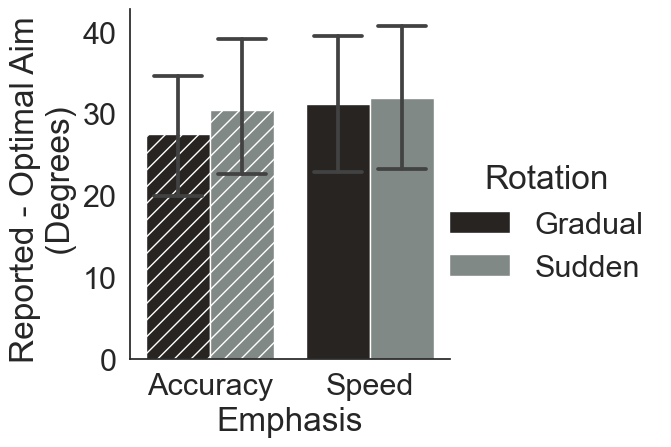

In [287]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'aim report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim_targetwise_participant)

x1, x2 = 0, 1
y, h, col = df_aim_targetwise_participant['aim - optimal report'].mean()+0.1, 0.02, 'k'
g.set(ylabel='Reported - Swiped \n (Degrees)')
g.set(title=None)
# plt.text(0, y+h+50, "*", ha='center', va='bottom', color=col)
# plt.text(1, y+h+50, "*", ha='center', va='bottom', color=col)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [279]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

df_aim_targetwise_participant['report_perf'] = df_aim_targetwise_participant['aim report - performance']
model = ols(
    'report_perf ~ C(Rotation) * C(Emphasis)', data=df_aim_targetwise_participant).fit()
sm.stats.anova_lm(model, typ=2)

C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\1397722879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aim_targetwise_participant['report_perf'] = df_aim_targetwise_participant['aim report - performance']


,sum_sq,df,F,PR(>F)
C(Rotation),5.984788e+04,1.0,6.275378,0.012988
C(Emphasis),4.468293e+03,1.0,0.468525,0.494407
C(Rotation):C(Emphasis),6.758600e+03,1.0,0.708676,0.400823
Residual,2.040904e+06,214.0,NaN,NaN


In [280]:
df_aim_targetwise_participant['aim_optim'] = df_aim_targetwise_participant['aim - optimal report']
model = ols(
    'aim_optim ~ C(Rotation) * C(Emphasis)', data=df_aim_targetwise_participant).fit()
sm.stats.anova_lm(model, typ=2)

C:\Users\tejas\AppData\Local\Temp\ipykernel_18040\1375944840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aim_targetwise_participant['aim_optim'] = df_aim_targetwise_participant['aim - optimal report']


,sum_sq,df,F,PR(>F)
C(Rotation),6173.975168,1.0,2.079879,0.150714
C(Emphasis),2868.658241,1.0,0.966389,0.326693
C(Rotation):C(Emphasis),387.000401,1.0,0.130372,0.718403
Residual,635244.133718,214.0,NaN,NaN


In [283]:
stat.ttest_1samp(df_aim_targetwise_participant.loc[df_aim_targetwise_participant['Rotation'] == 'Gradual', 'report_perf'].values, popmean=0)

TtestResult(statistic=1.6738610814801171, pvalue=0.09689956941814579, df=114)

In [282]:
df_aim_targetwise_participant.loc[df_aim_targetwise_participant['Rotation'] == 'Gradual', 'report_perf'].values

array([ -63.96566839, -132.98083015,  -36.29695011,  -66.59728377,
       -171.47099653,  -45.24360352, -170.48818912,  -11.16380779,
       -153.48100981,   26.81947788, -144.69375102, -125.23131945,
       -110.50272329,  -16.62894611,  -76.89497885, -137.94050011,
         39.39650455, -153.04585882,  -37.44829626,  -25.4877591 ,
        -22.28946182, -156.45840633,   10.86141238,   88.97063646,
        -40.12938157,    5.34586405,  -61.14789675,   79.58374189,
        -81.20986615,   68.90457119, -121.28951222,  100.91354637,
       -104.75531689,   90.99673249,  -81.43629279,   41.46169722,
       -105.44632276,  -85.86329494,  -98.02904245,   80.15276761,
        -96.88421538,  161.02720406,  -53.74158451,   82.49147272,
        -93.01153662,   27.07741213,  -94.05026031,   25.66058035,
       -104.78573582,   59.68472925,  -70.17430998,   54.7102965 ,
        -72.09428892,   57.03161945,  -58.15958285,  176.7914714 ,
        -61.16982834,  154.06344675,  -44.3381987 ,  148.47209

# First three aiming plots

In [72]:
def clean_data_aim(df):
    # Drop columns: 'repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN' and 281 other columns
    df = df.drop(columns=['repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN', 'repeat_instructions.thisN', 'repeat_instructions.thisIndex', 'accuracy_instructions.thisRepN', 'accuracy_instructions.thisTrialN', 'accuracy_instructions.thisN', 'accuracy_instructions.thisIndex', 'speed_instructions.thisRepN', 'speed_instructions.thisTrialN', 'speed_instructions.thisN', 'speed_instructions.thisIndex', 'baseline_trials.thisRepN', 'baseline_trials.thisTrialN', 'baseline_trials.thisN', 'baseline_trials.thisIndex', 'rotated_blocks.thisRepN', 'rotated_blocks.thisTrialN', 'rotated_blocks.thisN', 'rotated_blocks.thisIndex', 'rotated_trials.thisRepN', 'rotated_trials.thisTrialN', 'rotated_trials.thisN', 'rotated_trials.thisIndex', 'unlearning_trials.thisTrialN', 'unlearning_trials.thisN', 'unlearning_trials.thisIndex', 'relearning_blocks.thisRepN', 'relearning_blocks.thisTrialN', 'relearning_blocks.thisN', 'relearning_blocks.thisIndex', 'relearning_trials.thisRepN', 'relearning_trials.thisTrialN', 'relearning_trials.thisN', 'relearning_trials.thisIndex', 'instr_adv_mouse_0.started', 'instr_adv_text_0.started', 'instr_adv_mouse_0.x', 'instr_adv_mouse_0.y', 'instr_adv_mouse_0.leftButton', 'instr_adv_mouse_0.midButton', 'instr_adv_mouse_0.rightButton', 'instr_adv_mouse_0.time', 'consent0.started', 'consent_text0.started', 'consent0_keyresp.started', 'consent0_keyresp.keys', 'consent0_keyresp.rt', 'consent_text1.started', 'consent1.started', 'consent1_keyresp.started', 'consent1_keyresp.keys', 'consent1_keyresp.rt', 'consent2.started', 'consent_text2.started', 'consent2_keyresp.started', 'consent2_keyresp.keys', 'consent2_keyresp.rt', 'consent_text3.started', 'consent3_keyresp.started', 'consent3.started', 'consent3_keyresp.keys', 'consent3_keyresp.rt', 'consent_text4.started', 'consent4_keyresp.started', 'consent4.started', 'consent4_keyresp.keys', 'consent4_keyresp.rt', 'agree.started', 'disagree.started', 'consent5.started', 'agree.numClicks', 'agree.timesOn', 'agree.timesOff', 'disagree.numClicks', 'disagree.timesOn', 'disagree.timesOff', 'age.started', 'respAge.started', 'gender.started', 'genderResp2.started', 'nextButton.started', 'mouse.started', 'respAge.response', 'respAge.rt', 'genderResp2.text', 'mouse.x', 'mouse.y', 'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'mouse.clicked_name', 'instr_adv_mouse_05.started', 'instr_adv_text_05.started', 'instr_adv_mouse_05.x', 'instr_adv_mouse_05.y', 'instr_adv_mouse_05.leftButton', 'instr_adv_mouse_05.midButton', 'instr_adv_mouse_05.rightButton', 'instr_adv_mouse_05.time', 'instr_adv_text_1.started', 'instr_adv_mouse_1.started', 'instr_adv_mouse_1.x', 'instr_adv_mouse_1.y', 'instr_adv_mouse_1.leftButton', 'instr_adv_mouse_1.midButton', 'instr_adv_mouse_1.rightButton', 'instr_adv_mouse_1.time', 'instr_adv_text_2.started', 'instr_adv_mouse_2.started', 'instr_adv_mouse_2.x', 'instr_adv_mouse_2.y', 'instr_adv_mouse_2.leftButton', 'instr_adv_mouse_2.midButton', 'instr_adv_mouse_2.rightButton', 'instr_adv_mouse_2.time', 'instr_acc_adv_text_3.started', 'instr_adv_mouse_3_acc.started', 'instr_adv_mouse_3_acc.x', 'instr_adv_mouse_3_acc.y', 'instr_adv_mouse_3_acc.leftButton', 'instr_adv_mouse_3_acc.midButton', 'instr_adv_mouse_3_acc.rightButton', 'instr_adv_mouse_3_acc.time', 'repeat_instructions_text.started', 'repeat_instr_adv.started', 'repeat_instr_repeat.started', 'repeat_instr_adv.x', 'repeat_instr_adv.y', 'repeat_instr_adv.leftButton', 'repeat_instr_adv.midButton', 'repeat_instr_adv.rightButton', 'repeat_instr_adv.time', 'repeat_instr_repeat.keys', 'text_countdown_2.started', 'cursor.started', 'cursor.stopped', 'target_baseline.started', 'mouse_baseline.started', 'cursor_baseline.started', 'target_baseline.stopped', 'mouse_baseline.stopped', 'cursor_baseline.stopped', 'mouse_baseline.x', 'mouse_baseline.y', 'mouse_baseline.leftButton', 'mouse_baseline.midButton', 'mouse_baseline.rightButton', 'mouse_baseline.time', 'mouse_baseline.clicked_name', 'break_text.started', 'break_mouse.started', 'improve_text.started', 'break_mouse.x', 'break_mouse.y', 'break_mouse.leftButton', 'break_mouse.midButton', 'break_mouse.rightButton', 'break_mouse.time', 'target_rotated.started', 'mouse_rotated.started', 'cursor_rotated.started', 'mouse_rotated.x', 'mouse_rotated.y', 'mouse_rotated.leftButton', 'mouse_rotated.midButton', 'mouse_rotated.rightButton', 'mouse_rotated.time', 'instr_adv_text_4.started', 'instr_adv_mouse_4.started', 'instr_adv_mouse_4.x', 'instr_adv_mouse_4.y', 'instr_adv_mouse_4.leftButton', 'instr_adv_mouse_4.midButton', 'instr_adv_mouse_4.rightButton', 'instr_adv_mouse_4.time', 'instr_adv_text_5.started', 'instr_adv_mouse_5.started', 'instr_adv_mouse_5.x', 'instr_adv_mouse_5.y', 'instr_adv_mouse_5.leftButton', 'instr_adv_mouse_5.midButton', 'instr_adv_mouse_5.rightButton', 'instr_adv_mouse_5.time', 'instr_adv_text_55.started', 'instr_adv_mouse_55.started', 'instr_adv_mouse_55.x', 'instr_adv_mouse_55.y', 'instr_adv_mouse_55.leftButton', 'instr_adv_mouse_55.midButton', 'instr_adv_mouse_55.rightButton', 'instr_adv_mouse_55.time', 'phase_cntdown.started', 'target_aiming.started', 'aim_typing_instruction.started', 'end_routine_instruction.started', 'aim_cursor.started', 'aim_report_end.started', 'aim_report_end.keys', 'aim_report_end.rt', 'target_swiping.started', 'swipe_cursor.started', 'aim_swipe_mouse.started', 'swiping_trial_instuctions.started', 'aim_swipe_mouse.leftButton', 'aim_swipe_mouse.midButton', 'aim_swipe_mouse.rightButton', 'aim_swipe_mouse.time', 'text.started', 'text.stopped', 'instr_adv_text_6.started', 'instr_adv_mouse_6.started', 'instr_adv_mouse_6.x', 'instr_adv_mouse_6.y', 'instr_adv_mouse_6.leftButton', 'instr_adv_mouse_6.midButton', 'instr_adv_mouse_6.rightButton', 'instr_adv_mouse_6.time', 'target_unlearning.started', 'mouse_unlearning.started', 'cursor_unlearning.started', 'mouse_unlearning.x', 'mouse_unlearning.y', 'mouse_unlearning.leftButton', 'mouse_unlearning.midButton', 'mouse_unlearning.rightButton', 'mouse_unlearning.time', 'no_score_break_text.started', 'no_score_break_mouse.started', 'no_score_break_mouse.x', 'no_score_break_mouse.y', 'no_score_break_mouse.leftButton', 'no_score_break_mouse.midButton', 'no_score_break_mouse.rightButton', 'no_score_break_mouse.time', 'study_done.started', 'study_done_mouse.started', 'thoughts_on_study.started', 'study_done_adv.started', 'study_done_mouse.x', 'study_done_mouse.y', 'study_done_mouse.leftButton', 'study_done_mouse.midButton', 'study_done_mouse.rightButton', 'study_done_mouse.time', 'thoughts_on_study.text', 'pre_debrief_text.started', 'pre_debrief_mouse.started', 'pre_debrief_mouse.x', 'pre_debrief_mouse.y', 'pre_debrief_mouse.leftButton', 'pre_debrief_mouse.midButton', 'pre_debrief_mouse.rightButton', 'pre_debrief_mouse.time', 'debrief_text.started', 'debrief_mouse.started', 'debrief_mouse.x', 'debrief_mouse.y', 'debrief_mouse.leftButton', 'debrief_mouse.midButton', 'debrief_mouse.rightButton', 'debrief_mouse.time', 'text_countdown.started', 'participant', 'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 280', 'instr_spd_adv_text_3.started', 'instr_adv_mouse_3_spd.started', 'instr_adv_mouse_3_spd.x', 'instr_adv_mouse_3_spd.y', 'instr_adv_mouse_3_spd.leftButton', 'instr_adv_mouse_3_spd.midButton', 'instr_adv_mouse_3_spd.rightButton', 'instr_adv_mouse_3_spd.time', 'phase_cntdown.stopped', 'Unnamed: 281', 'repeat_instr_repeat.rt', 'Unnamed: 282', 'unlearning_trials.thisRepN', 'aim_report_text.started'])
    # Filter rows based on column: 'aim_swipe_mouse.x'
    df = df[df['aim_swipe_mouse.x'].notna()]
    # Filter rows based on column: 'aim report'
    df = df[df['aim report'].notna()]
    # Drop column: 'aim_report_text.text'
    # df = df.drop(columns=['aim_report_text.text'])
    # Drop column: 'cursor trajectory'
    df = df.drop(columns=['cursor trajectory'])
    return df

df_aim = clean_data_aim(df.copy()).reset_index().drop('index', axis = 1)
# df_aim.head()

In [73]:
df_aim['aim report'] = df_aim['aim report']*4
df_aim['trial'] = np.tile(np.arange(16), 62)
df_aim.loc[df_aim['p_id']%2 == 0, 'Rotation'] = 'Sudden'
df_aim.loc[df_aim['p_id']%2 == 1, 'Rotation'] = 'Gradual'

df_aim.loc[df_aim['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 2, 'Emphasis'] = 'Speed'
df_aim.loc[df_aim['p_id']%4 == 3, 'Emphasis'] = 'Speed'

df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 45
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 135
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 225
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 315

df_aim['optimal report'] = df_aim['target angle'] - 60
df_aim.loc[df_aim['optimal report'] < 0, 'optimal report'] = 360-15
df_aim['optimal report - report'] = df_aim['optimal report'] - df_aim['aim report']

df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report'] = 360 - df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report']
df_aim.loc[df_aim['optimal report - report'] < -180, 'optimal report - report'] = -360 - df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report']



In [74]:
def find_aim_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  dotprod = np.dot(ab, ac)
  ab_magnitudes = np.linalg.norm(ab)
  ac_magnitudes = np.linalg.norm(ac)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))

  return np.degrees(angles)

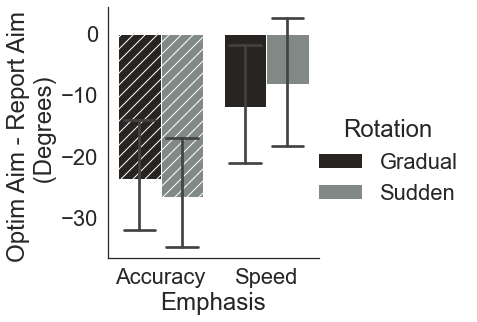

In [75]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'optimal report - report', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Optim Aim - Report Aim \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [62]:
aim_swipe_error = []
swipe_angles = []
for i in range(len(df_aim)):
    x_target = df_aim.loc[i, 'target_x']
    y_target = df_aim.loc[i, 'target_y']
    x_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.x'])[-1]
    y_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.y'])[-1]
    swipe_angle = find_aim_angles(np.array([0, 0]), np.array([1, 0]), np.array([x_end, y_end]))

    report_angle = df_aim.loc[i, 'aim report']
    aim_swipe_error.append((report_angle - swipe_angle))
    swipe_angles.append(swipe_angle)
    
df_aim['aim report - swipe'] = aim_swipe_error
# df_aim['swipe angle'] = swipe_angles

# df_aim['optimal report - swipe'] = df_aim['optimal report'] - (df_aim['aim report'] - df_aim['aim report - swipe'])

C:\Users\tejas\AppData\Local\Temp\ipykernel_10036\173691674.py:12: RuntimeWarning: invalid value encountered in double_scalars
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))


In [67]:
df_aim['swipe angle'] = swipe_angles

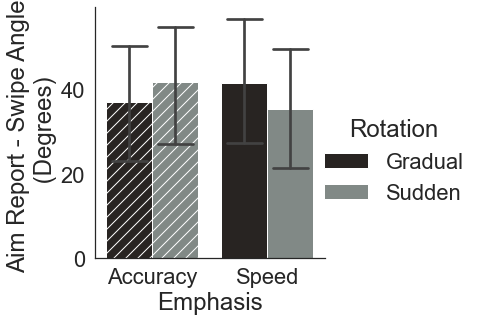

In [65]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'aim report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Aim Report - Swipe Angle \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [69]:
df_aim['optimal report - swipe'] = df_aim['optimal report'] - df_aim['swipe angle']

df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe'] = 360 - df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe']
df_aim.loc[df_aim['optimal report - swipe'] < -180, 'optimal report - swipe'] = -360 - df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe']


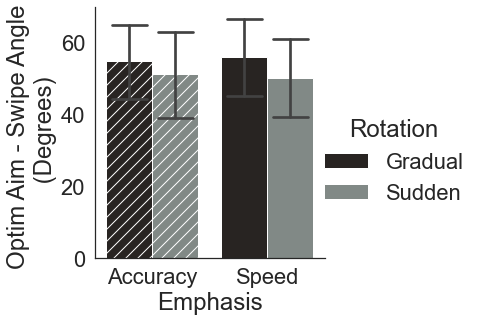

In [70]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'optimal report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Optim Aim - Swipe Angle \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])
